In this notebook I tried to apply timeseries forecasting, but due to many duplicate time values per country I was not able to pull it off.

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.time_series import *
from pycaret.classification import plot_model

In [206]:
file = pd.ExcelFile("food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx")
df = file.parse('CropStats')
df = df.set_index(df.columns[0])
df.index.name = None

## Clean Data
Columns with too many null values or meaningless information are dropped.  
Columns with unclear names are renamed.  
For the subnational column null values are filled up with corresponding values from the national column.  
For yield, production, and hectares, if one of them is null but the others in the same row are not, the null one can be calculated. Here we need to pay attention to not divide by 0.  
We chose to focus on wheat, so we will be filtering the df accordingly.  
We also added columns with logarithmic transformations for yield, production, and hectares.

In [207]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)
df.loc[df['subnational'].isna(), 'subnational'] = df['national']
# Calculate yield
mask = df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna() & ~df['hectares_ha'].isna() & df['hectares_ha'] != 0
df.loc[mask, 'yield_tonnes_ha'] = df['production_tonnes'] / df['hectares_ha']
df.dropna(subset=['yield_tonnes_ha'], inplace=True)
# Calculate production
mask = df['production_tonnes'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['hectares_ha'].isna()
df.loc[mask, 'production_tonnes'] = df['yield_tonnes_ha'] * df['hectares_ha']
df.dropna(subset=['production_tonnes'], inplace=True)
# Calculate hectares
mask = df['hectares_ha'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna()
df.loc[mask, 'hectares_ha'] = df['yield_tonnes_ha'] * df['production_tonnes']
df.dropna(subset=['hectares_ha'], inplace=True)
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares_ha'] = df['hectares_ha'].astype(float)
df['production_tonnes'] = df['production_tonnes'].astype(float)
df['yield_tonnes_ha'] = df['yield_tonnes_ha'].astype(float)
# Filter for wheat
df = df[df['crop'] == 'wheat']
# Remove the crop column
df.drop('crop', axis=1, inplace =True)
# Logarithmic transformations
# df['log_yield'] = np.log1p(df['yield_tonnes_ha'])
# df['log_hectares'] = np.log1p(df['production_tonnes'])
# df['log_production'] = np.log1p(df['hectares_ha'])

# df = df.drop(['log_yield', 'log_hectares', 'log_production'], axis=1, inplace=True)

In [208]:
df[df['national'] == 'Belgium']

,national,subnational,hectares_ha,production_tonnes,year,yield_tonnes_ha
175,Belgium,Belgium,212139.0,753093.45,1961,3.5500
176,Belgium,Belgium,212221.0,876472.73,1962,4.1300
177,Belgium,Belgium,201443.0,743324.67,1963,3.6900
178,Belgium,Belgium,217656.0,916331.76,1964,4.2100
179,Belgium,Belgium,229353.0,864660.81,1965,3.7700
180,Belgium,Belgium,231643.0,604588.23,1966,2.6100
181,Belgium,Belgium,216676.0,1001043.12,1967,4.6200
182,Belgium,Belgium,220347.0,969526.80,1968,4.4000
183,Belgium,Belgium,215759.0,888927.08,1969,4.1200
184,Belgium,Belgium,198233.0,876189.86,1970,4.4200


In [210]:
df.loc[:, "year"] = pd.to_datetime(df["year"], format='%Y')
# df = df.set_index('year')
# df.index = df.index.to_period(freq='A')
belgium = df[df['national'] == 'Belgium']
belgium.head()

,national,subnational,hectares_ha,production_tonnes,year,yield_tonnes_ha
175,Belgium,Belgium,212139.0,753093.45,1961-01-01,3.55
176,Belgium,Belgium,212221.0,876472.73,1962-01-01,4.13
177,Belgium,Belgium,201443.0,743324.67,1963-01-01,3.69
178,Belgium,Belgium,217656.0,916331.76,1964-01-01,4.21
179,Belgium,Belgium,229353.0,864660.81,1965-01-01,3.77


In [211]:
X = belgium[['year', 'yield_tonnes_ha', 'production_tonnes', 'hectares_ha']]
belgium.describe()

,hectares_ha,production_tonnes,yield_tonnes_ha
count,57.000000,5.700000e+01,57.000000
mean,206263.631579,1.343943e+06,6.530132
std,12097.673802,3.940915e+05,1.903033
min,173113.000000,6.045882e+05,2.610000
25%,197743.000000,9.996994e+05,4.700000
50%,209532.000000,1.363080e+06,6.787100
75%,215000.000000,1.676789e+06,8.280000
max,231643.000000,2.019347e+06,10.015200


In [212]:
exp_reg = setup(data=X, fold=3, target='yield_tonnes_ha' , fh=5, session_id=123, index='year')

,Description,Value
0,session_id,123
1,Target,yield_tonnes_ha
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(57, 3)"
5,Transformed data shape,"(57, 3)"
6,Transformed train set shape,"(52, 3)"
7,Transformed test set shape,"(5, 3)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [213]:
best_model = compare_models()

In [186]:
tuned_model = tune_model(best_model)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:46:17
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors w/ Cond. Deseasonalize & Detrending


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 36, n_neighbors = 46

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

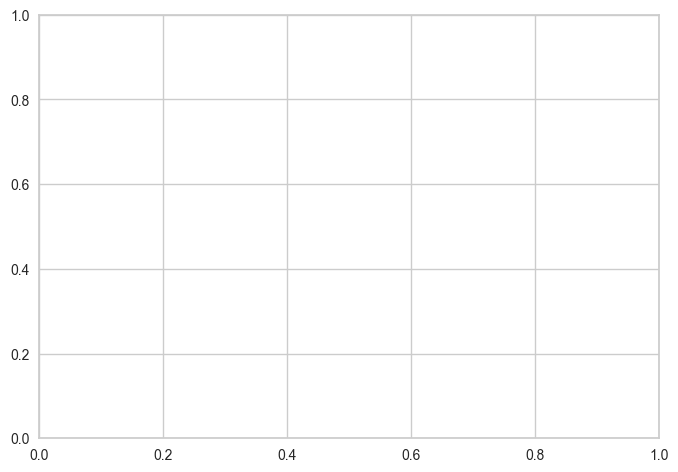

In [175]:
evaluate_model(tuned_model)

In [201]:
predict_model(best_model, fh= np.arange(50, 60))

,y_pred
2057,14.1417
2058,14.2608
2059,14.3799
2060,14.4990
2061,14.6182
2062,14.7373
2063,14.8564
2064,14.9755
2065,15.0946
2066,15.2137


<b>USA</b>

In [227]:
france = df[df['national'] == 'France']
france.describe()

,hectares_ha,production_tonnes,yield_tonnes_ha
count,2589.000000,2.589000e+03,2589.000000
mean,222227.110154,7.732209e+05,3.336880
std,167633.970095,9.459215e+05,2.311682
min,63.000000,1.656000e+02,0.300000
25%,84400.000000,1.718580e+05,1.376519
50%,202503.000000,4.497760e+05,2.437463
75%,329805.000000,9.068510e+05,5.160816
max,883700.000000,6.129295e+06,9.932212


In [228]:
X = france[['year', 'yield_tonnes_ha', 'production_tonnes', 'hectares_ha']]

In [229]:
france.year.value_counts()

1959-01-01    22
1974-01-01    22
1986-01-01    22
1985-01-01    22
1984-01-01    22
              ..
1941-01-01    21
1942-01-01    21
1944-01-01    21
1900-01-01    21
1943-01-01    20
Name: year, Length: 119, dtype: int64

In [221]:
exp_reg = setup(data=X, fold=3, target='yield_tonnes_ha' , fh=5, session_id=123, index='year')

ValueError: Index may not have duplicate values! Please check and correct before passing to pycaret